# 02_DiD_estimates.ipynb

In [18]:
import statsmodels.formula.api as smf
from differences import ATTgt
from differences.did.pscore_cal import pscore_mle
from matplotlib import pyplot as plt
from statsmodels.stats.weightstats import ttest_ind

import figure_and_table_constants
import figure_utilities
from analysis_utilities import produce_summary_statistics, aggregate_by_time_and_plot, aggregate_by_event_time_and_plot

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [19]:
# Create dictionaries to map between string represetation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value + 1 for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key + 1: value for key, value in enumerate(value_vars)}

In [20]:
# Choose covariates to include in D.R. model.

# Run produce summary statistics on the DataFrame to add pre-treatment covariate columns.
summary_statistics, variable_display_names_dict = produce_summary_statistics(df, 'file_date')
variable_display_names_dict['twenty_seventeen'] = 'Zestimate, Jan. 2017'
variable_display_names_dict['twenty_eighteen'] = 'Zestimate, Jan. 2018'
pre_treatment_panels = ["Panel A: Pre-treatment Zestimates",
                        "Panel B: Census Tract Characteristics",
                        "Panel C: Case Initiation",
                        "Panel D: Defendant and Plaintiff Characteristics"]
summary_statistics = summary_statistics.loc[pre_treatment_panels, :]
potential_covariates = summary_statistics.index.get_level_values(1)
p_values = []
df.loc[:, 'final_month_of_panel_zestimate'] = df.loc[:, '2022-12']  # Create alias column for Patchy.
for potential_covariate in potential_covariates:
    # Get p-value from regression of outcome on covariates.
    p_y = (smf.ols(formula=f"final_month_of_panel_zestimate ~ {potential_covariate}",
                   data=df,
                   missing='drop')
           .fit().pvalues.loc[potential_covariate])
    # Get p-value from regression of treatment on covariates.
    p_x = (smf.ols(formula=f"judgment_for_plaintiff ~ {potential_covariate}",
                   data=df,
                   missing='drop')
           .fit().pvalues.loc[potential_covariate])
    p_values.append((p_y, p_x))
covariate_exploration_df = (pd.DataFrame(p_values,
                                        columns=["Zestimate, Dec. 2022", "Plaintiff victory"],
                                        index=summary_statistics.index))
covariate_exploration_df = pd.concat([covariate_exploration_df], axis=1, keys=['Dependent Variable'])
covariate_exploration_df.index = covariate_exploration_df.index.set_names(['',
                                                                          '\\emph{Independent Variable}'])
# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "pre_treatment_covariate_tests.tex")
latex = (covariate_exploration_df
         .rename(index=variable_display_names_dict)
         .style
         .format(formatter="{:0.2f}")
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llcc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")
         .replace("{*}", "{3cm}"))
latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{3-4}\n")
latex = "\\\\\n".join(latex)
with open(filename, 'w') as file:
    file.write(latex)
covariate_exploration_df

Dependent Variable  \
                                                                             Zestimate, Dec. 2022   
                                                 \emph{Independent Variable}                        
Panel A: Pre-treatment Zestimates                twenty_seventeen                    0.000000e+00   
                                                 change_in_zestimates               1.333639e-118   
Panel B: Census Tract Characteristics            frac_coll_plus2010                  3.717161e-12   
                                                 job_density_2013                    1.395642e-03   
                                                 med_hhinc2016                       6.404776e-05   
                                                 poor_share2010                      6.968171e-01   
                                                 popdensity2010                      5.573163e-47   
                                                 rent_twobed2015                     7.588784e-21   
                                                 share_white2010                     3.438580e-09   
                                                 traveltime15_2010                   2.084840e-41   
Panel C: Case Initiation                         for_cause                           1.382887e-02   
                                                 no_cause                            9.841596e-01   
                                                 non_payment                         3.130263e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                            3.665050e-01   
                                                 hasAttyP                            6.082612e-01   
                                                 isEntityD                           2.174817e-02   
                                                 isEntityP                           6.244069e-01   

                                                                                                
                                                                             Plaintiff victory  
                                                 \emph{Independent Variable}                    
Panel A: Pre-treatment Zestimates                twenty_seventeen                 8.297724e-04  
                                                 change_in_zestimates             2.744060e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010               6.527090e-02  
                                                 job_density_2013                 6.321597e-01  
                                                 med_hhinc2016                    1.312078e-02  
                                                 poor_share2010                   5.684150e-03  
                                                 popdensity2010                   9.170102e-03  
                                                 rent_twobed2015                  4.541611e-02  
                                                 share_white2010                  2.113541e-03  
                                                 traveltime15_2010                1.571842e-02  
Panel C: Case Initiation                         for_cause                        6.842697e-01  
                                                 no_cause                         3.110684e-02  
                                                 non_payment                      7.697358e-01  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                         2.745403e-30  
                                                 hasAttyP                         4.740066e-01  
                                                 isEntityD                        3.663339e-01  
                                                 isEntityP                        1.265898e-01

In [21]:
# Balance only on covariates which predict the outcome variable.
predicts_zestimates_mask = covariate_exploration_df.iloc[:, 0] <= 0.05

# Build treatment mean columns.
pd.options.mode.chained_assignment = None
treatment_means, variable_display_names_dict = produce_summary_statistics(df.copy().loc[df['judgment_for_plaintiff'] == 1, :], 'file_date')
treatment_means = (treatment_means.loc[pre_treatment_panels, :]
                   .loc[predicts_zestimates_mask, 'mean']
                   .rename("Cases Won by Plaintiff"))
pre_treatment_covariates = treatment_means.index.get_level_values(1).tolist()  # Save pre-treatment covariates for use in D.R. DiD estimator.
pd.options.mode.chained_assignment = 'warn'

# Calculate propensity scores for every observation.
df.loc[:, 'propensity_score'] = pd.Series(pscore_mle(df.dropna(subset=pre_treatment_covariates)['judgment_for_plaintiff'],
                                                     exog=df.dropna(subset=pre_treatment_covariates)[pre_treatment_covariates],
                                                     weights=None)[0])  # Calculate propensity scores.

# Build unweighted columns.
difference_unadjusted = []
p_values_unadjusted = []
for covariate in pre_treatment_covariates:
    result = smf.ols(formula=f"{covariate} ~ judgment_for_plaintiff",
                     data=df,
                     missing='drop').fit()
    difference_unadjusted.append(result.params.loc['judgment_for_plaintiff'])
    p_values_unadjusted.append(result.pvalues.loc['judgment_for_plaintiff'])
difference_unadjusted = pd.Series(difference_unadjusted, index=treatment_means.index)
p_values_unadjusted = pd.Series(p_values_unadjusted, index=treatment_means.index)
unweighted_columns = pd.concat([difference_unadjusted, p_values_unadjusted], axis=1)
unweighted_columns.columns = ['Unweighted', '\\emph{p}']

# Build propensity score-weighted columns.
differences_propensity_score_adjusted = []
p_values_propensity_score_adjusted = []
for covariate in pre_treatment_covariates:
    propensity_score_adjusted_result = smf.ols(formula=f"{covariate} ~ judgment_for_plaintiff + propensity_score",
                                               data=df,
                                               missing='drop').fit()
    differences_propensity_score_adjusted.append(propensity_score_adjusted_result.params.loc['judgment_for_plaintiff'])
    p_values_propensity_score_adjusted.append(propensity_score_adjusted_result.pvalues.loc['judgment_for_plaintiff'])
differences_propensity_score_adjusted = pd.Series(differences_propensity_score_adjusted, index=treatment_means.index)
p_values_propensity_score_adjusted = pd.Series(p_values_propensity_score_adjusted, index=treatment_means.index)
propensity_score_weighted_columns = pd.concat(
    [differences_propensity_score_adjusted, p_values_propensity_score_adjusted], axis=1)
propensity_score_weighted_columns.columns = ['Weighted', '\\emph{p}']

difference_columns = pd.concat([unweighted_columns, propensity_score_weighted_columns], axis=1)
table_columns = [treatment_means, difference_columns]
balance_table = pd.concat(table_columns, axis=1, keys=['', 'Difference in Cases Won by Defendant'])

balance_table = balance_table.rename(index=variable_display_names_dict)
# TODO: Figure out how to make the outermost index labels wrap in LaTeX so that I don't have to shorten the panel labels below!
balance_table = balance_table.rename(index={"Panel A: Pre-treatment Zestimates": "Panel A",
                                             "Panel B: Census Tract Characteristics": "Panel B",
                                             "Panel C: Case Initiation": "Panel C",
                                             "Panel D: Defendant and Plaintiff Characteristics": "Panel D"})

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .style
         .format(thousands=",",
                 na_rep='',
                 formatter={('', 'Cases Won by Plaintiff'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'Unweighted'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', '\\emph{p}'): "{:,.2f}",
                            ('Difference in Cases Won by Defendant', 'Weighted'): "{:,.2f}",
                            ('', 'N'): "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llccccc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")).replace("{*}", "{3cm}")
latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{4-7}\n")
latex = "\\\\\n".join(latex)
with open(filename, 'w') as file:
    file.write(latex)
balance_table

\
                                                Cases Won by Plaintiff   
Panel A Zestimate, Jan. 2017                             291942.144891   
        Change, Jan. 2017 to Jan. 2019                    50491.595055   
Panel B Share with bachelor's degree                          0.253571   
        Jobs per square mile (2010)                        4158.018171   
        Median household income (2016)                    52087.323083   
        Population density (2010)                          9031.635095   
        Median two bedroom rent (2015)                     1093.360129   
        Share white (2010)                                    0.602099   
        Share with commute $<$15 minutes (2010)               0.286852   
Panel C For cause                                             0.124180   
Panel D Defendant is an entity                                0.011885   

                                                Difference in Cases Won by Defendant  \
                                                                          Unweighted   
Panel A Zestimate, Jan. 2017                                            26566.336480   
        Change, Jan. 2017 to Jan. 2019                                   2654.646842   
Panel B Share with bachelor's degree                                        0.012039   
        Jobs per square mile (2010)                                       263.898000   
        Median household income (2016)                                   2566.821918   
        Population density (2010)                                         944.988233   
        Median two bedroom rent (2015)                                     34.255627   
        Share white (2010)                                                  0.035089   
        Share with commute $<$15 minutes (2010)                            -0.011052   
Panel C For cause                                                           0.005299   
Panel D Defendant is an entity                                              0.003727   

                                                                         \
                                                 \emph{p}      Weighted   
Panel A Zestimate, Jan. 2017                     0.000830  14752.111698   
        Change, Jan. 2017 to Jan. 2019           0.274406  -2202.595977   
Panel B Share with bachelor's degree             0.065271      0.000360   
        Jobs per square mile (2010)              0.632160    322.235509   
        Median household income (2016)           0.013121   1497.447476   
        Population density (2010)                0.009170    787.729165   
        Median two bedroom rent (2015)           0.045416      6.432055   
        Share white (2010)                       0.002114      0.032776   
        Share with commute $<$15 minutes (2010)  0.015718     -0.002961   
Panel C For cause                                0.684270     -0.002859   
Panel D Defendant is an entity                   0.366334      0.000804   

                                                           
                                                 \emph{p}  
Panel A Zestimate, Jan. 2017                     0.139090  
        Change, Jan. 2017 to Jan. 2019           0.488017  
Panel B Share with bachelor's degree             0.964651  
        Jobs per square mile (2010)              0.638154  
        Median household income (2016)           0.244219  
        Population density (2010)                0.092318  
        Median two bedroom rent (2015)           0.767491  
        Share white (2010)                       0.018556  
        Share with commute $<$15 minutes (2010)  0.595844  
Panel C For cause                                0.856063  
Panel D Defendant is an entity                   0.887060

In [22]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
df = df.dropna(subset=['file_date', 'latest_docket_date'])


# TODO: Maybe delete this.. see how results change with missing indicator for the rent variable
df.loc[:, 'rent_twobed2015'] =  df['rent_twobed2015'].fillna(0)
df.loc[:, 'rent_twobed2015_missing'] = np.where(df['rent_twobed2015'] == 0, 1, 0)
pre_treatment_covariates.append('rent_twobed2015_missing')


print(f"Limiting sample to {len(df)} evictions for which we observe the filing date and the latest docket"
      f"date.")
cases_per_year = df[treatment_year_variable].value_counts()  # Store yearly case counts for use in figure titles in next cell.

# Reshape from wide to long.
df = pd.melt(df,
             id_vars=['case_number', treatment_month_variable, treatment_year_variable,
                      'judgment_for_plaintiff'] + pre_treatment_covariates,
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# TODO: POTENTIALLY DELETE THIS
df = df.loc[~df[treatment_month_variable].isin(['2019-05', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
                                                '2021-05']), :]

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, treatment_month_variable] = df[treatment_month_variable].replace(month_to_int_dictionary)
# Set treatment month to 0 for untreated observations.
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, treatment_month_variable] = np.NaN
df.loc[never_treated_mask, treatment_year_variable] = np.NaN

# Generate numeric version of case_number.
df.loc[:, 'case_number_numeric'] = df['case_number'].astype('category').cat.codes

# Set index.
df = df.set_index(['case_number', 'month'])

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_77765/3515972635.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'rent_twobed2015'] =  df['rent_twobed2015'].fillna(0)
/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_77765/3515972635.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'rent_twobed2015_missing'] = np.where(df['rent_twobed2015'] == 0, 1, 0)


Limiting sample to 2964 evictions for which we observe the filing date and the latest docketdate.


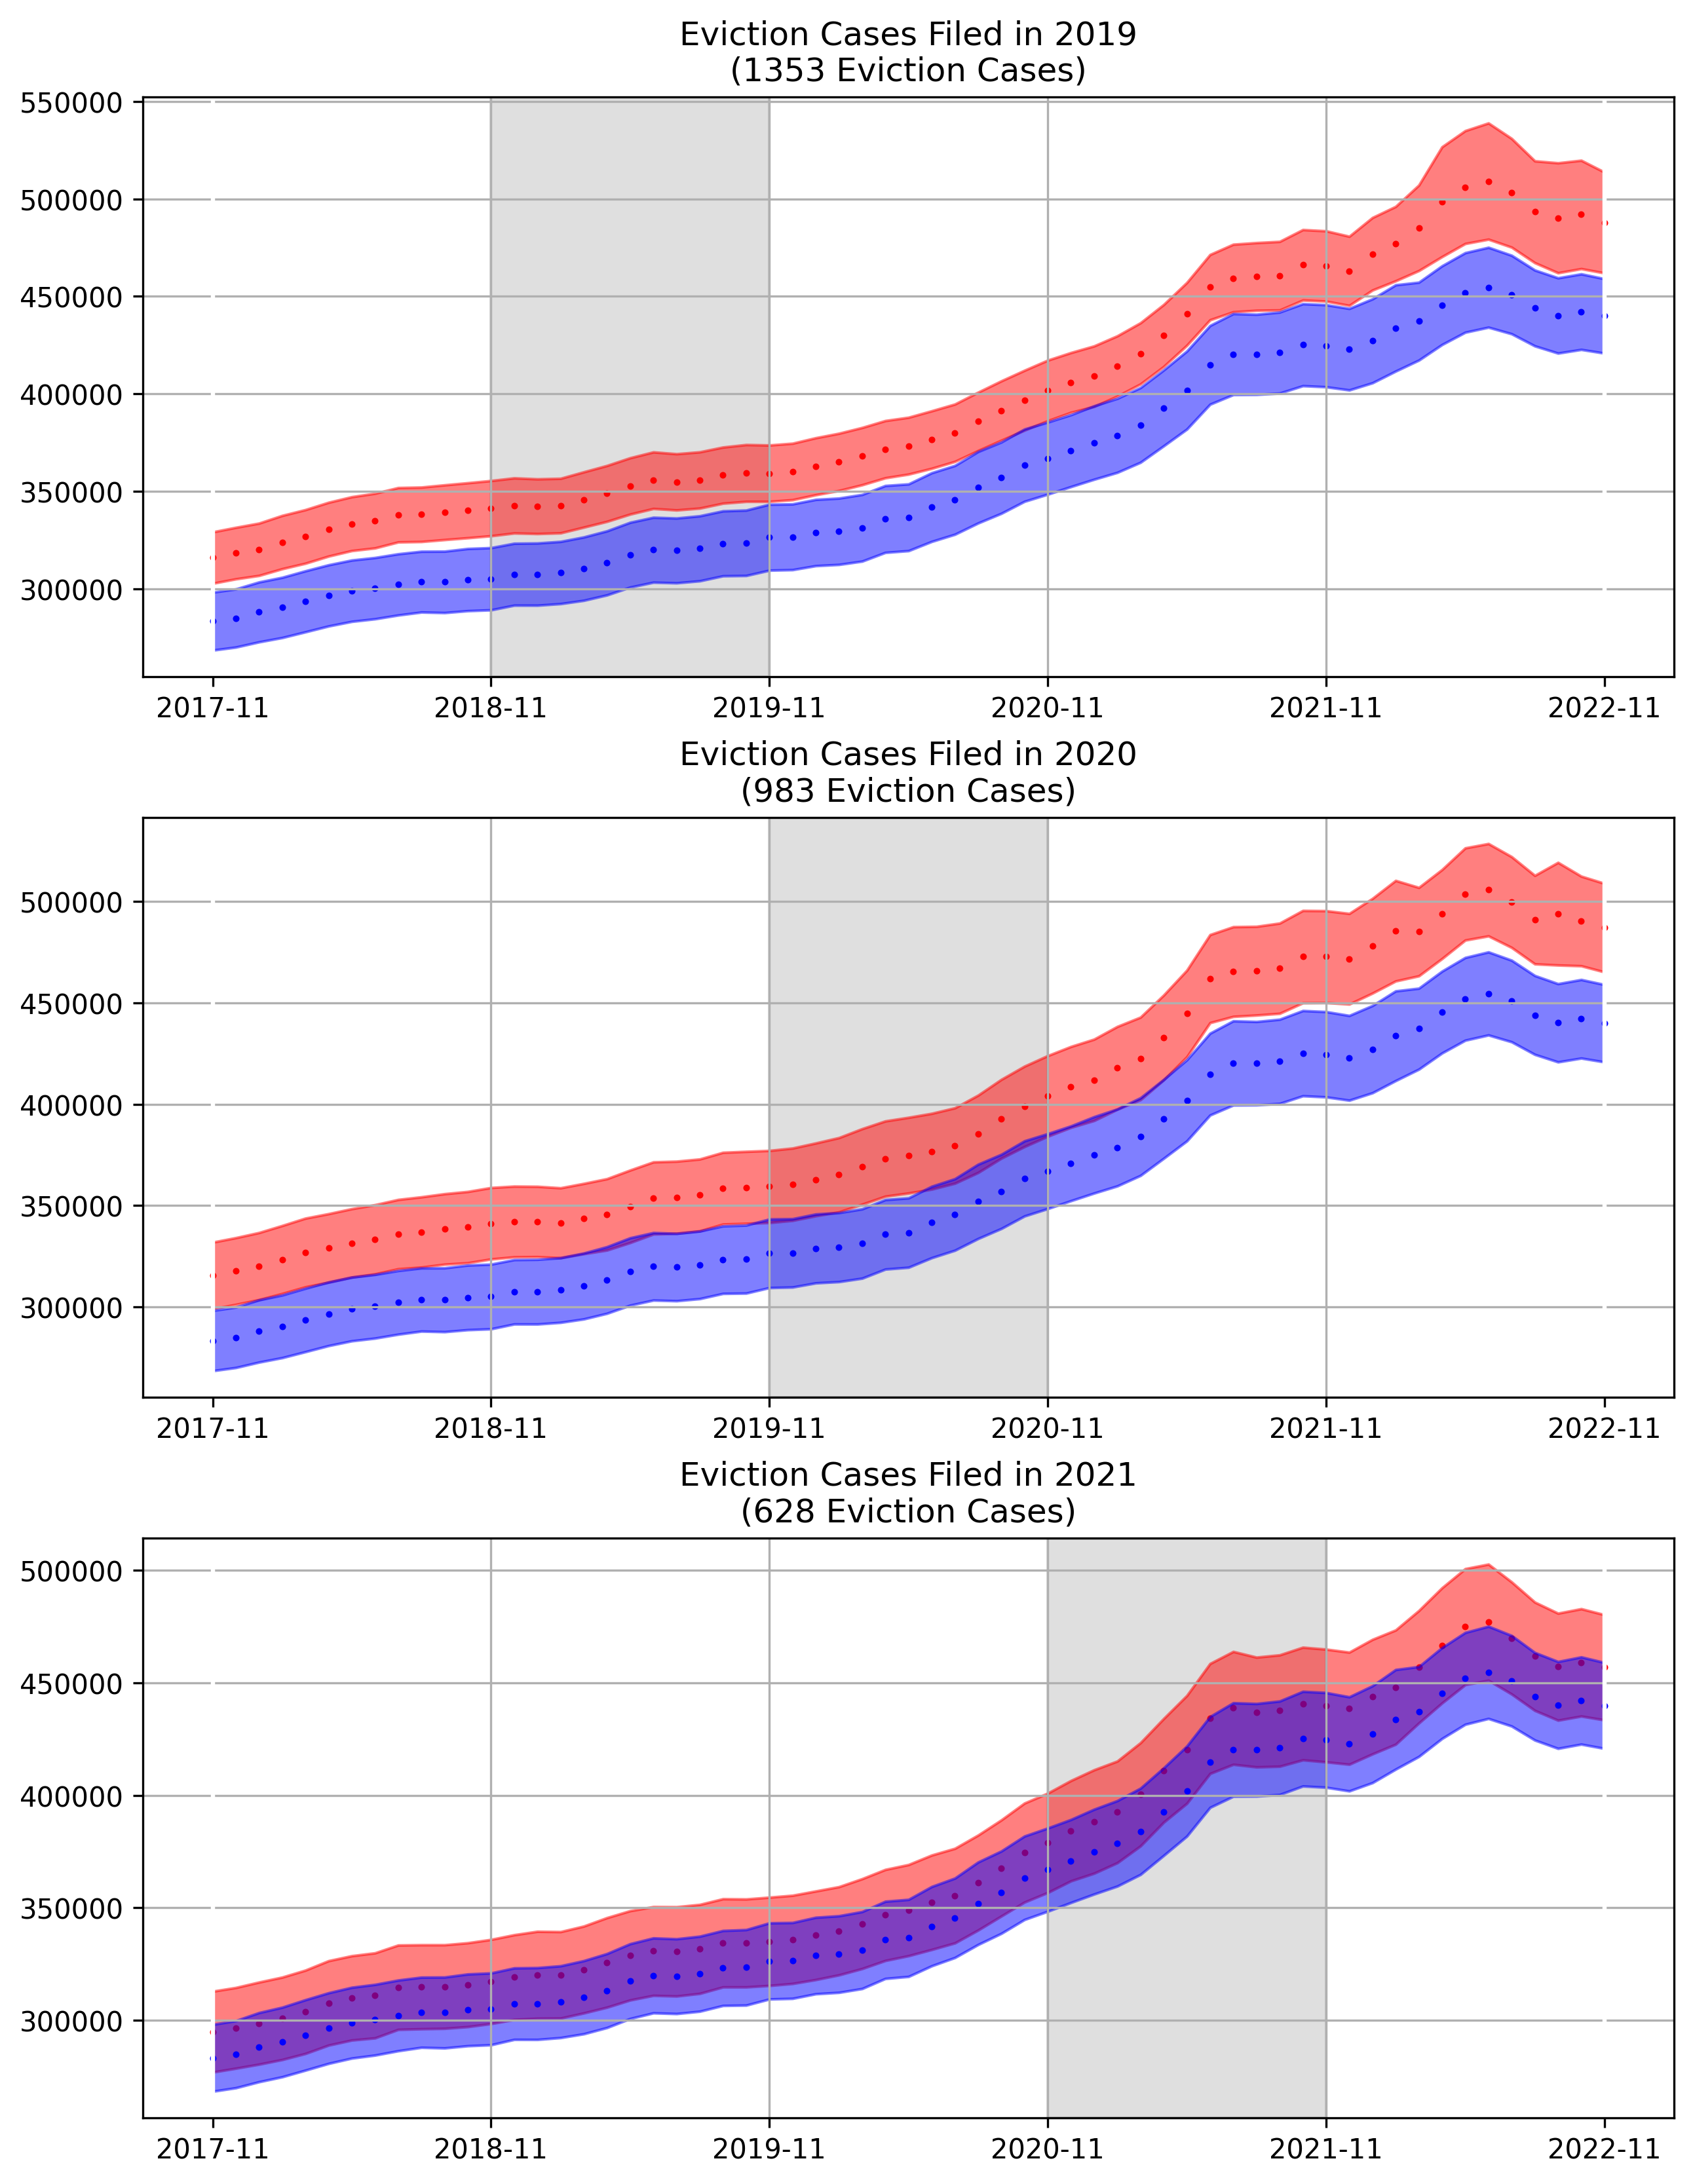

In [23]:
# Plot path of outcomes in treated group vs. control group, separately by year of filing.
# Plot.
aggregated_zestimates = (df
                         .copy().loc[(slice(None), slice(60, 120)),]
                         .groupby([treatment_year_variable, 'month'], dropna=False)['zestimate']
                         .agg([np.mean, np.std, 'count']))
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96 * aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96 * aggregated_zestimates['se']
treatment_times = aggregated_zestimates.index.get_level_values(treatment_year_variable).unique()
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8.5, 11))
for ax, aggregated_cohort in zip(axes, treatment_times):
    # No need to plot trends for untreated cohort.
    if np.isnan(aggregated_cohort):
        continue
    # Shade months during which treatment occurred in each aggregated cohort.
    start_shading = 12 * (int(aggregated_cohort) - 2017 - 1)
    end_shading = start_shading + 12
    ax.axvspan(start_shading, end_shading, color=figure_and_table_constants.Colors.LABELING_COLOR,
               alpha=0.25)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values

    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_treatment,
                                                     y_treatment,
                                                     y_upper_treatment,
                                                     y_lower_treatment,
                                                     point_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     error_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     edge_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     edge_style='-',
                                                     error_opacity=0.5)

    sub_df_control = (aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values(treatment_year_variable)
                                                .isna(), :])
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_control,
                                                     y_control,
                                                     y_upper_control,
                                                     y_lower_control,
                                                     point_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     error_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     edge_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     edge_style='-',
                                                     error_opacity=0.5)
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.grid(True)

    if treatment_date_variable == 'file_date':
        verb = 'Filed'
    elif treatment_date_variable == 'latest_docket_date':
        verb = 'Concluded'
    else:
        raise ValueError("Invalid treatment_date_variable.")
    ax.set_title(f"Eviction Cases {verb} in {int(aggregated_cohort)}\n"
                 f"({cases_per_year.loc[int(aggregated_cohort)]} Eviction Cases)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates_by_cohort.png"))

In [24]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1920/1920 [00:56<00:00, 33.69it/s]


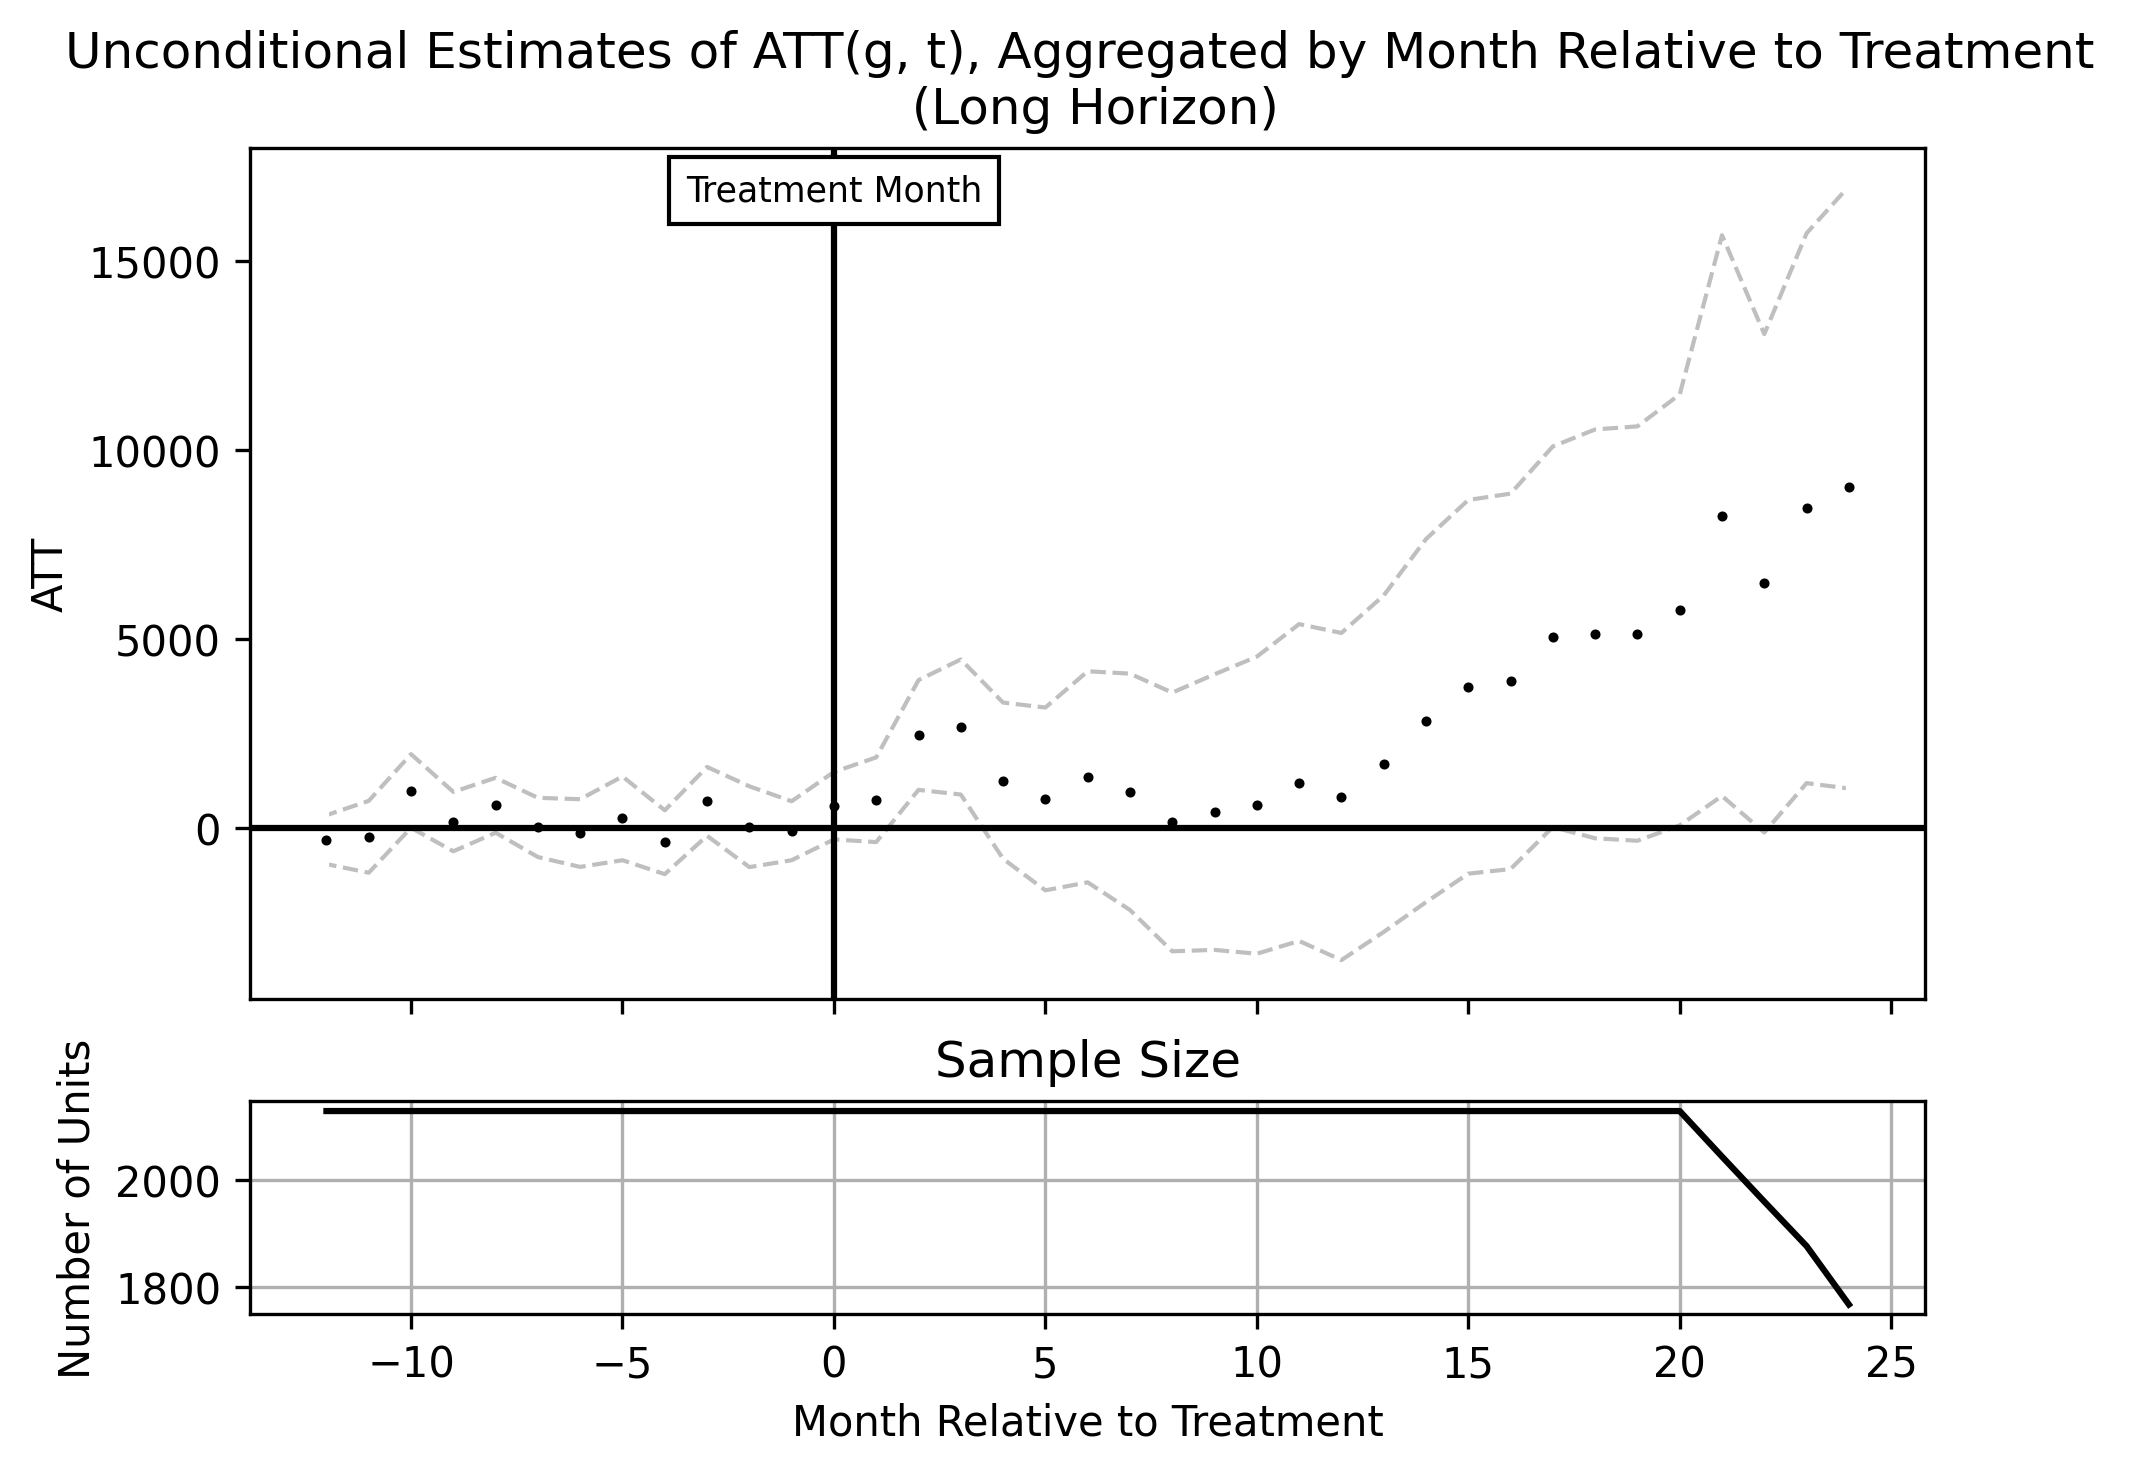

In [25]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=24,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

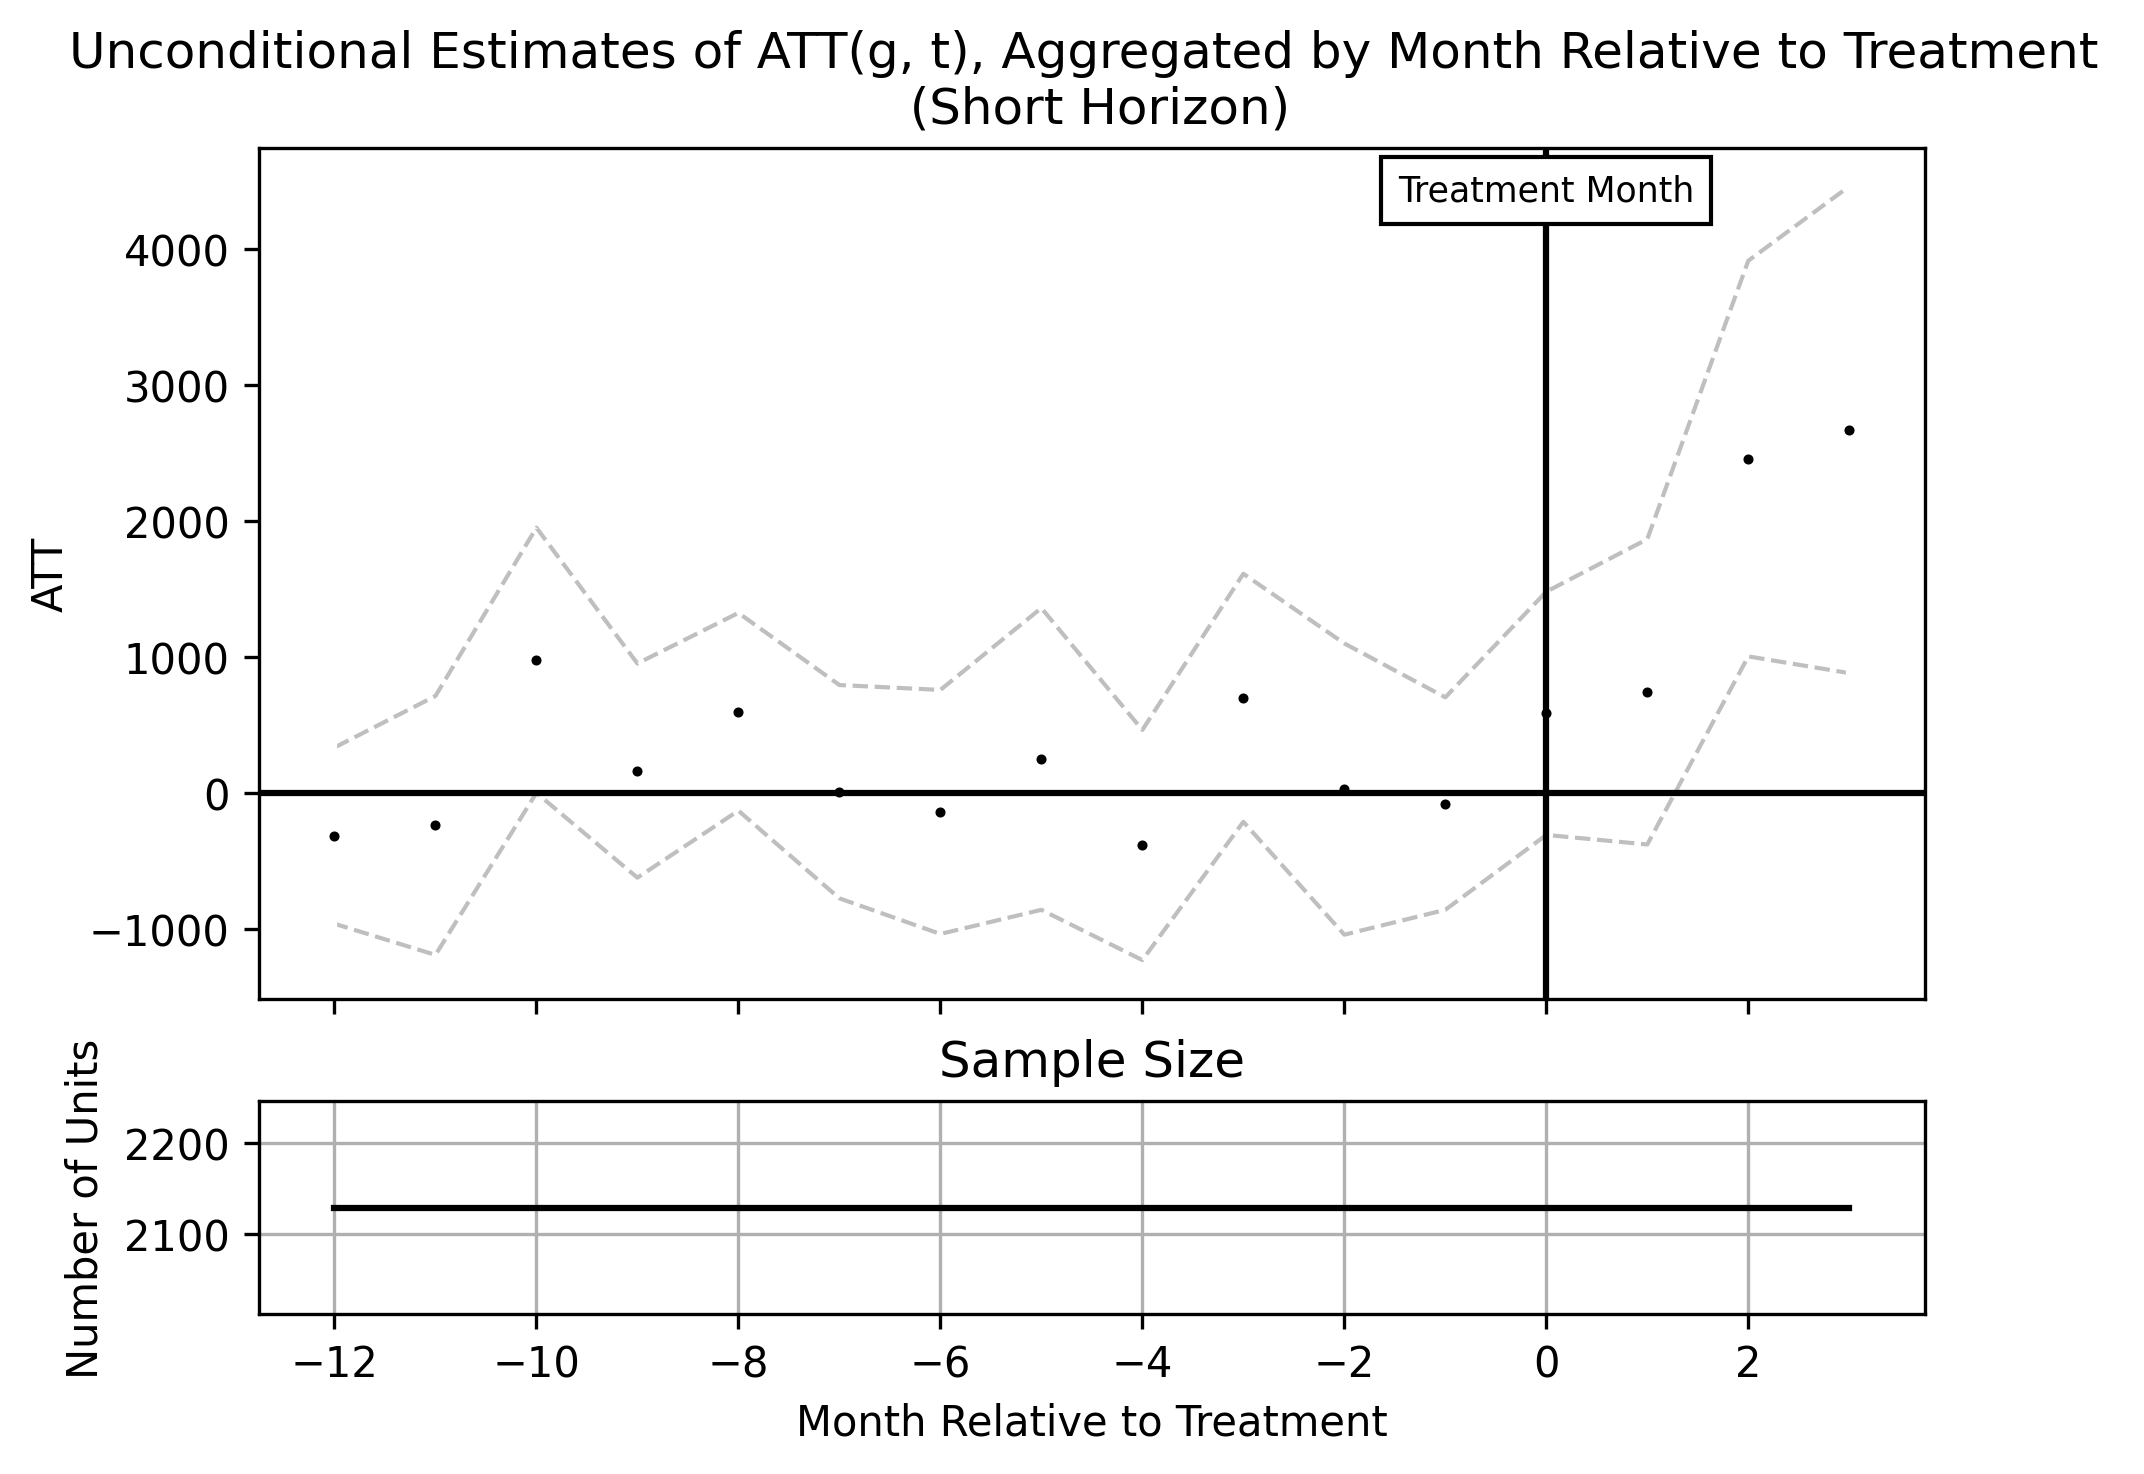

In [26]:
# Plot unconditional ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_short_horizon.png",
                                 start_period=-12, end_period=3,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

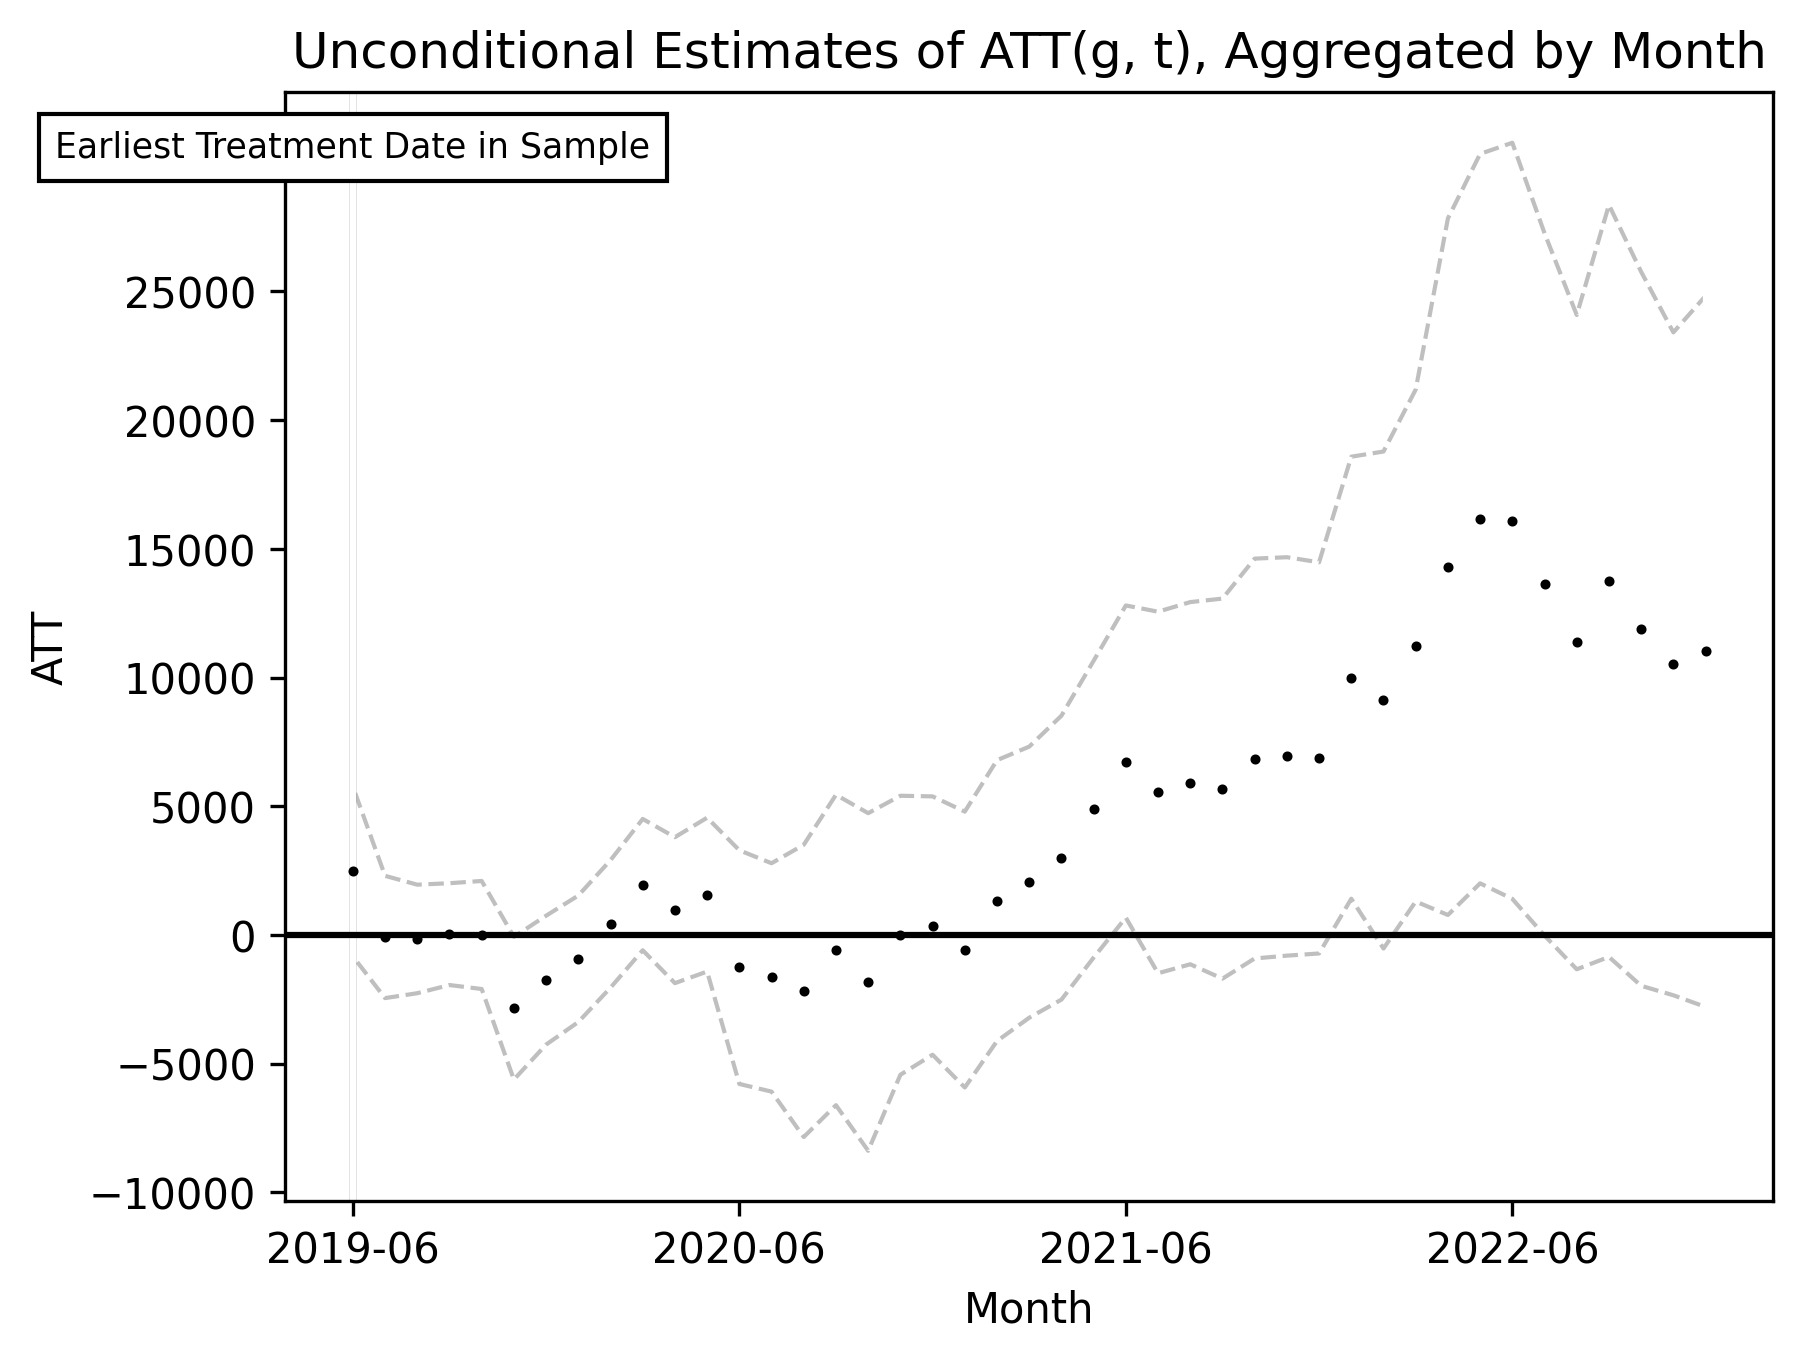

In [27]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

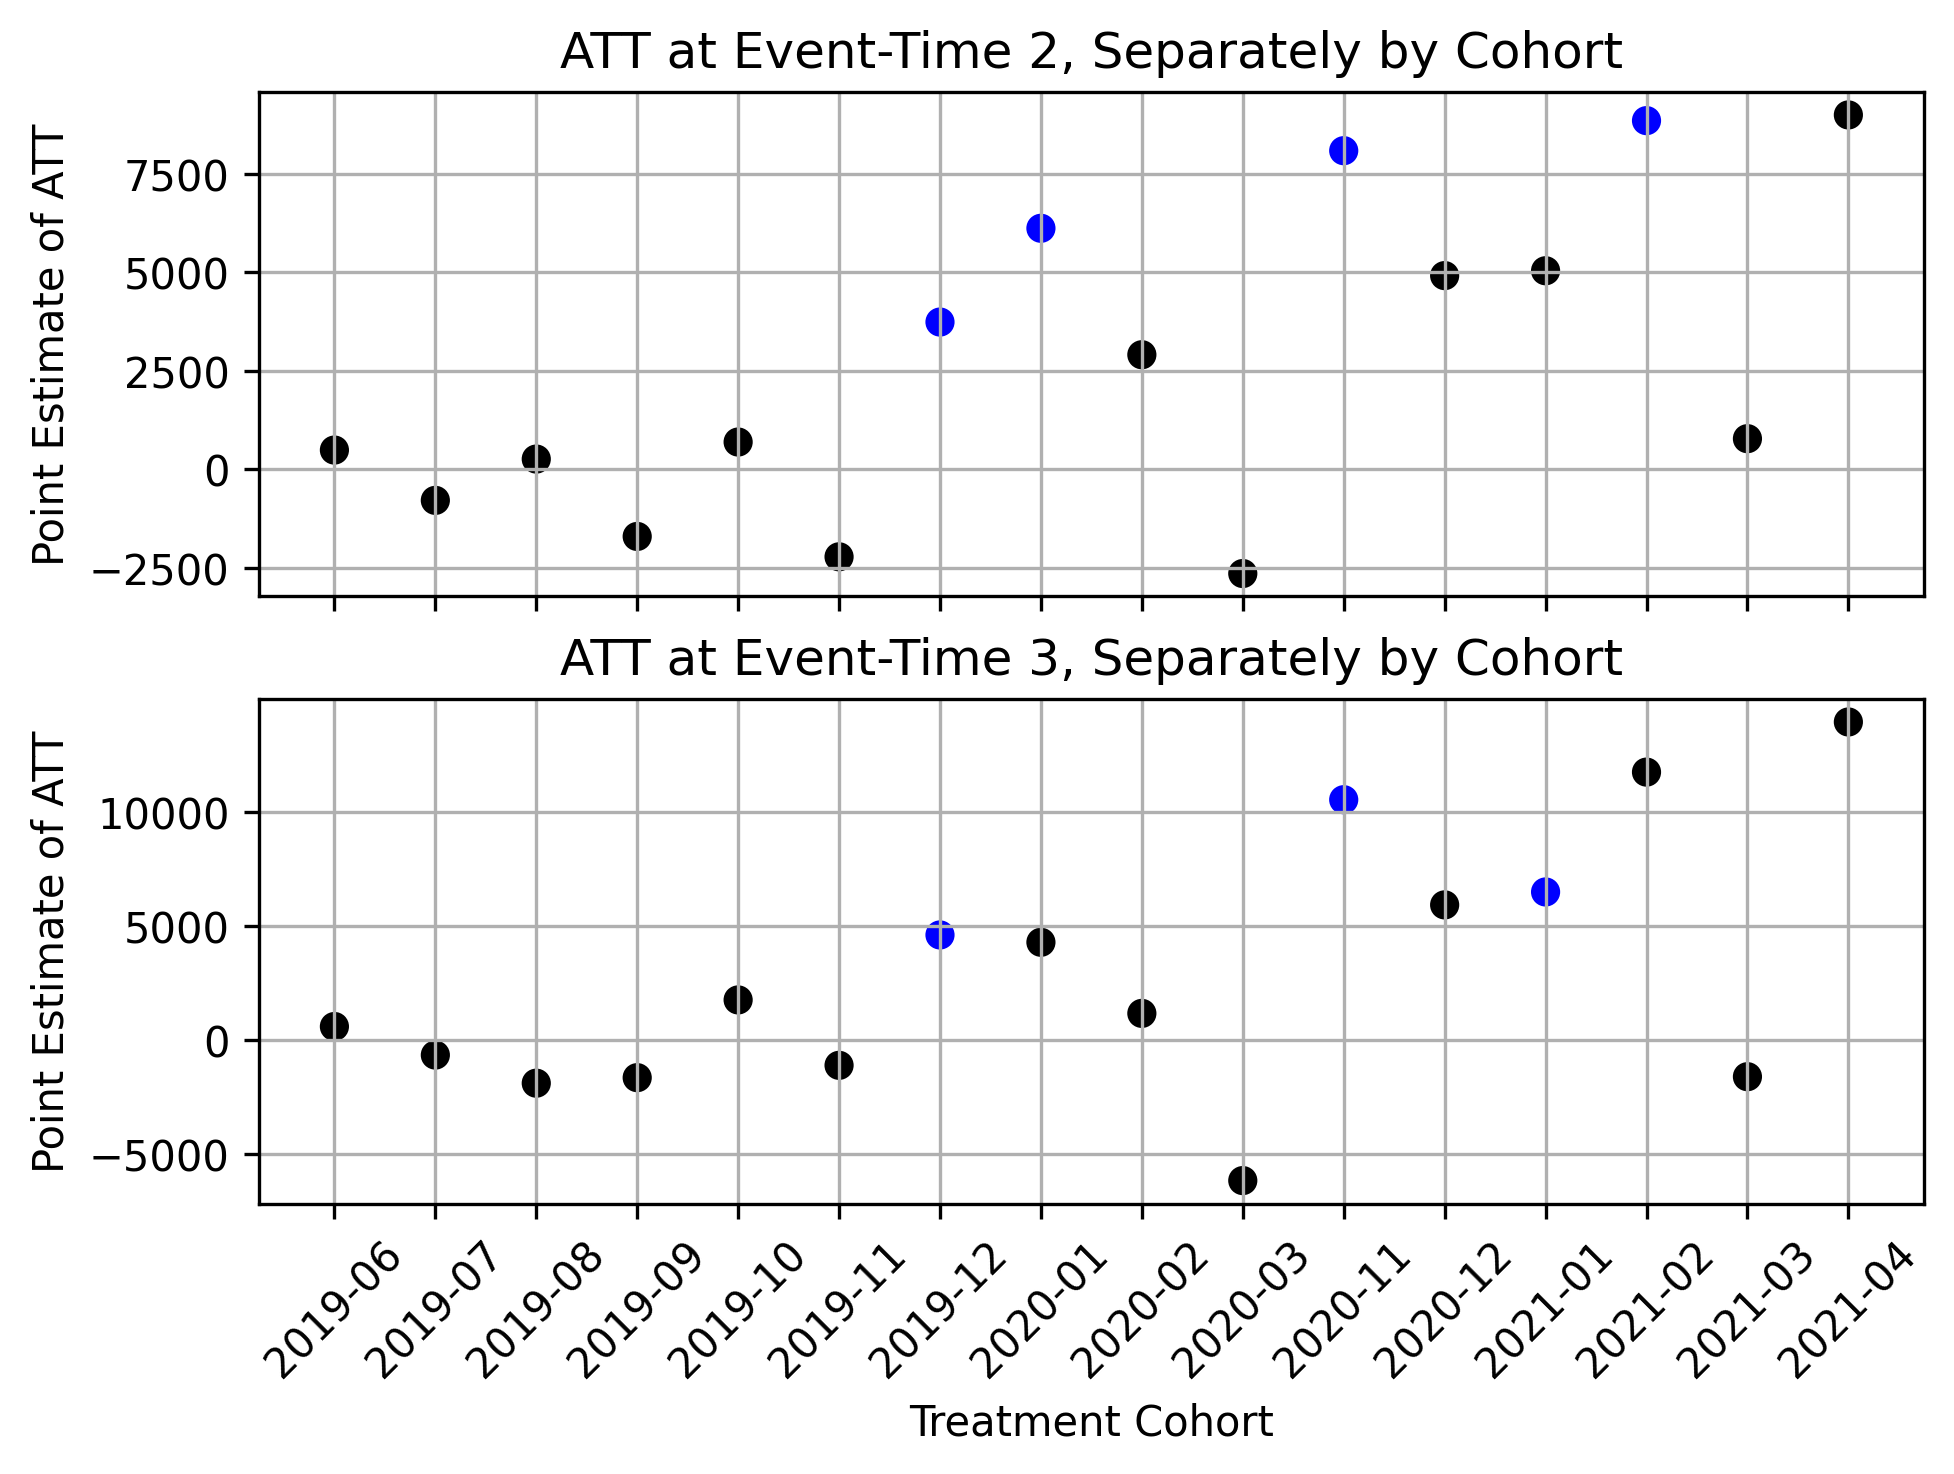

In [28]:
# Analyze heterogeneity in event-time 2 and 3 effects.

# Remove the outer indices of the columns so that we can easily access the ATT estimate and the significance of the estimate.
att_gts = result.copy()
att_gts.columns = att_gts.columns.droplevel(0).droplevel(0)

# Select ATT estimates from event time 2.
event_time_2_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'ATT']
event_time_2_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'zero_not_in_cband']

# Select ATT estimates from event time 3.
event_time_3_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'ATT']
event_time_3_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'zero_not_in_cband']

fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained')

for event_time_i_ATTS, event_time_i_significance, xlabel, ylabel, title, ax in zip([event_time_2_ATTs, event_time_3_ATTs],
                                                                                   [event_time_2_significance, event_time_3_significance],
                                                                                   ["", "Treatment Cohort"],
                                                                                   ["Point Estimate of ATT", "Point Estimate of ATT"],
                                                                                   ["ATT at Event-Time 2, Separately by Cohort",
                                                                                    "ATT at Event-Time 3, Separately by Cohort"],
                                                                                   axes):
    x = pd.Series(event_time_i_ATTS.index.get_level_values(0)).replace(int_to_month_dictionary).values.tolist()
    y = event_time_i_ATTS.values.tolist()
    colors = event_time_i_significance.replace({'*': 'blue', '': 'black'}).values.tolist()
    ax.scatter(x,
               y,
               color=colors)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
axes[1].tick_params('x', rotation=45)
plt.show()

In [29]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = 'zestimate ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1920/1920 [01:29<00:00, 21.44it/s]


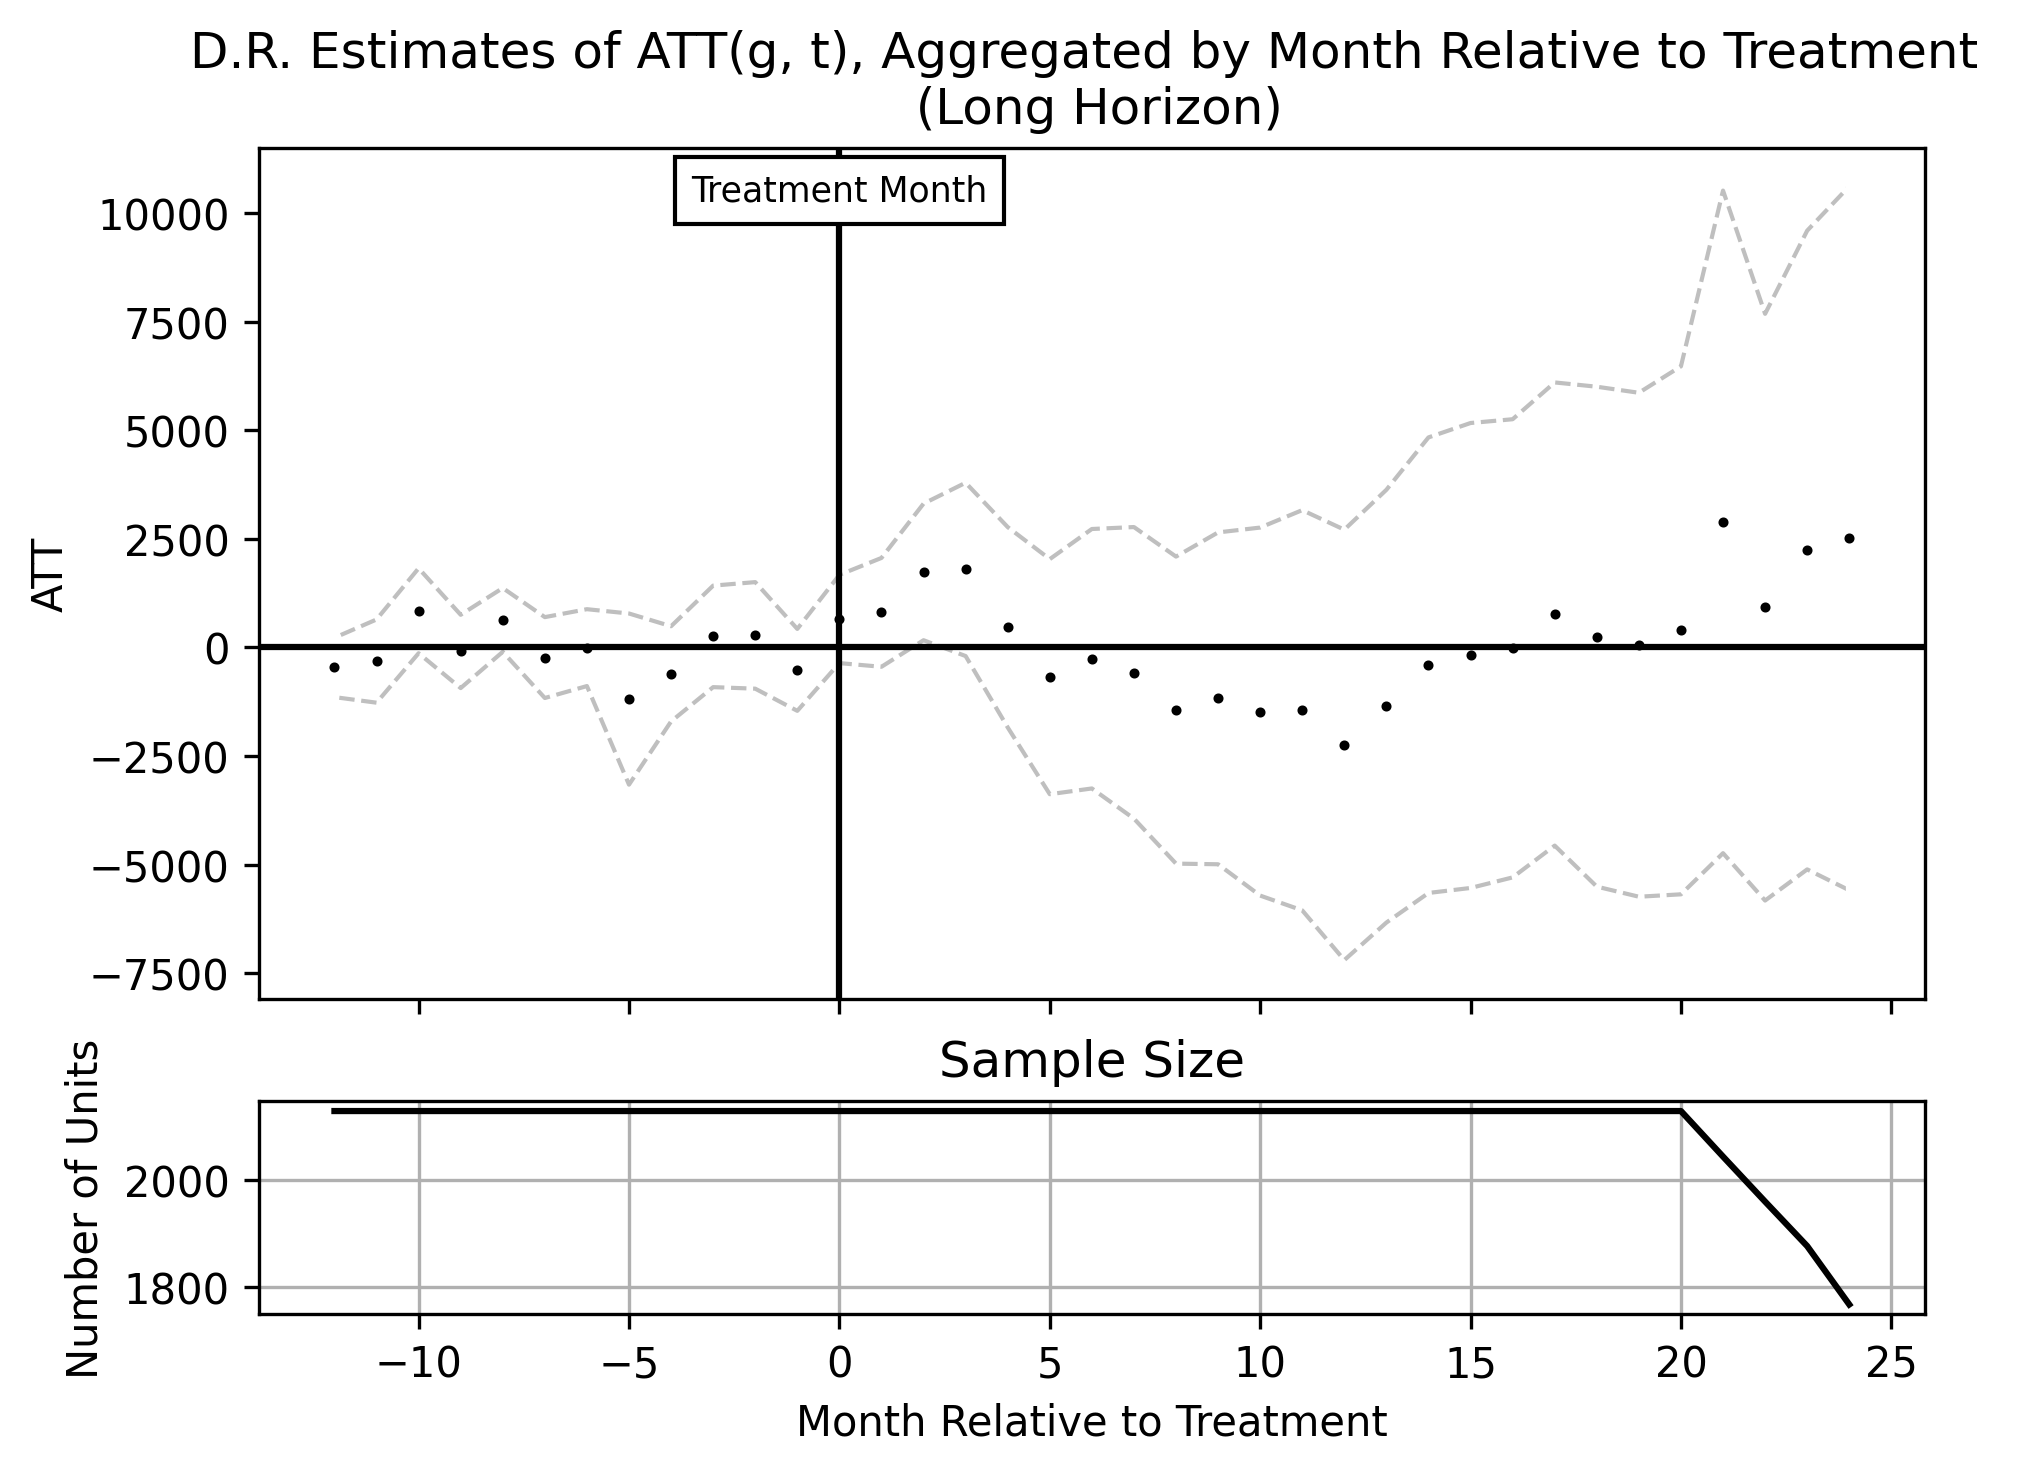

In [30]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=24,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

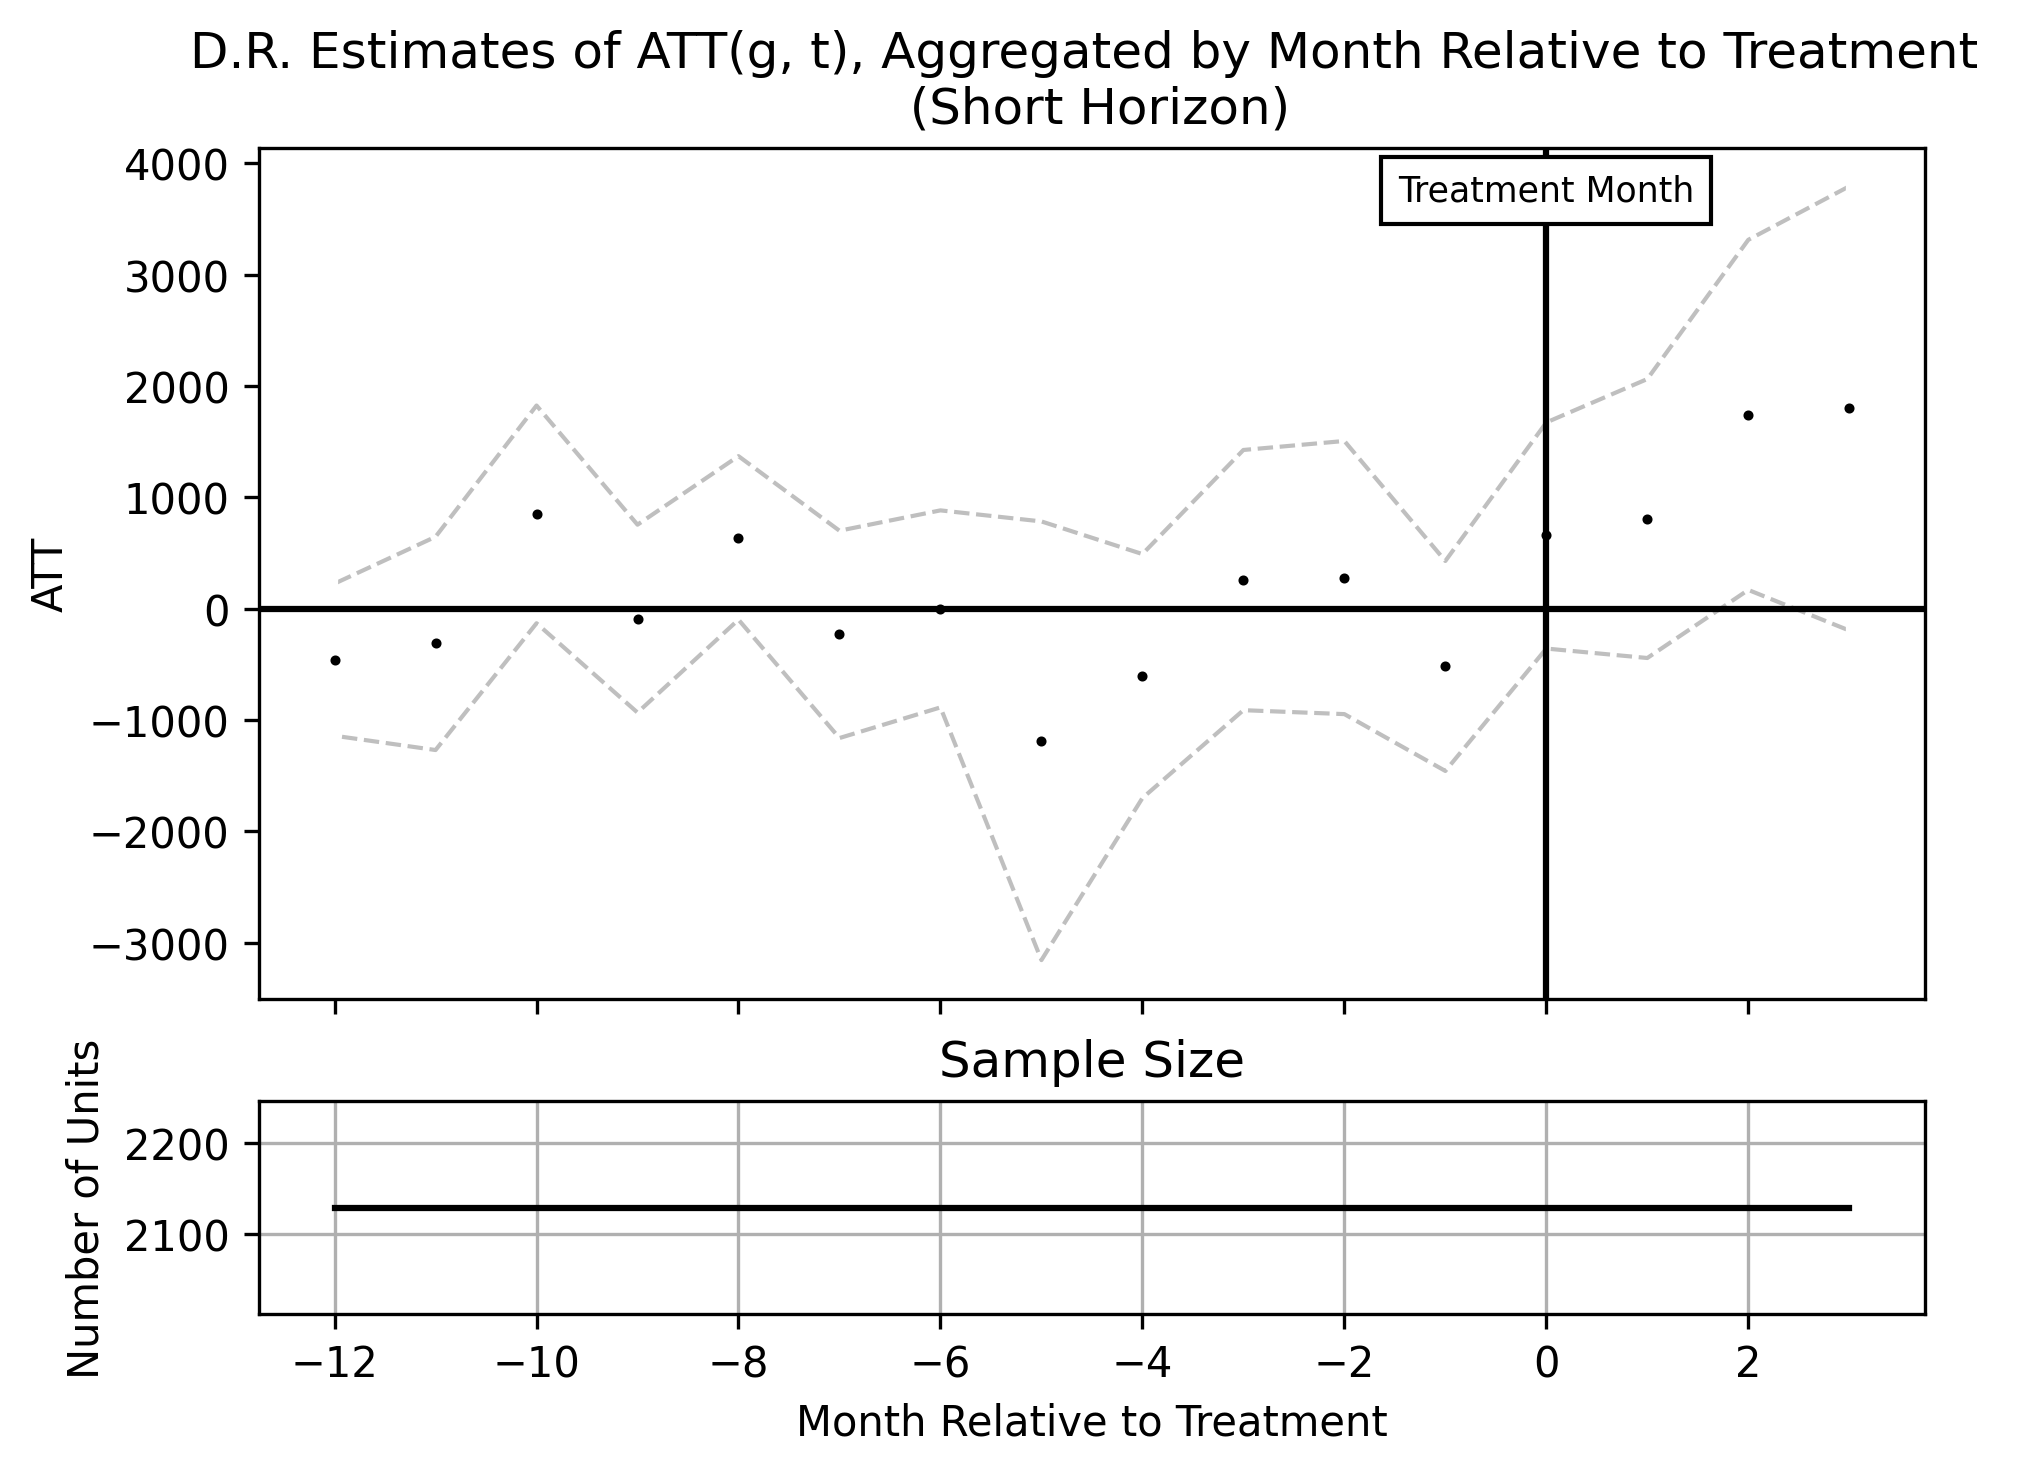

In [31]:
# Plot D.R. ATT(t-g)s on a short horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_short_horizon.png", start_period=-12,
                                 end_period=3,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Short Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

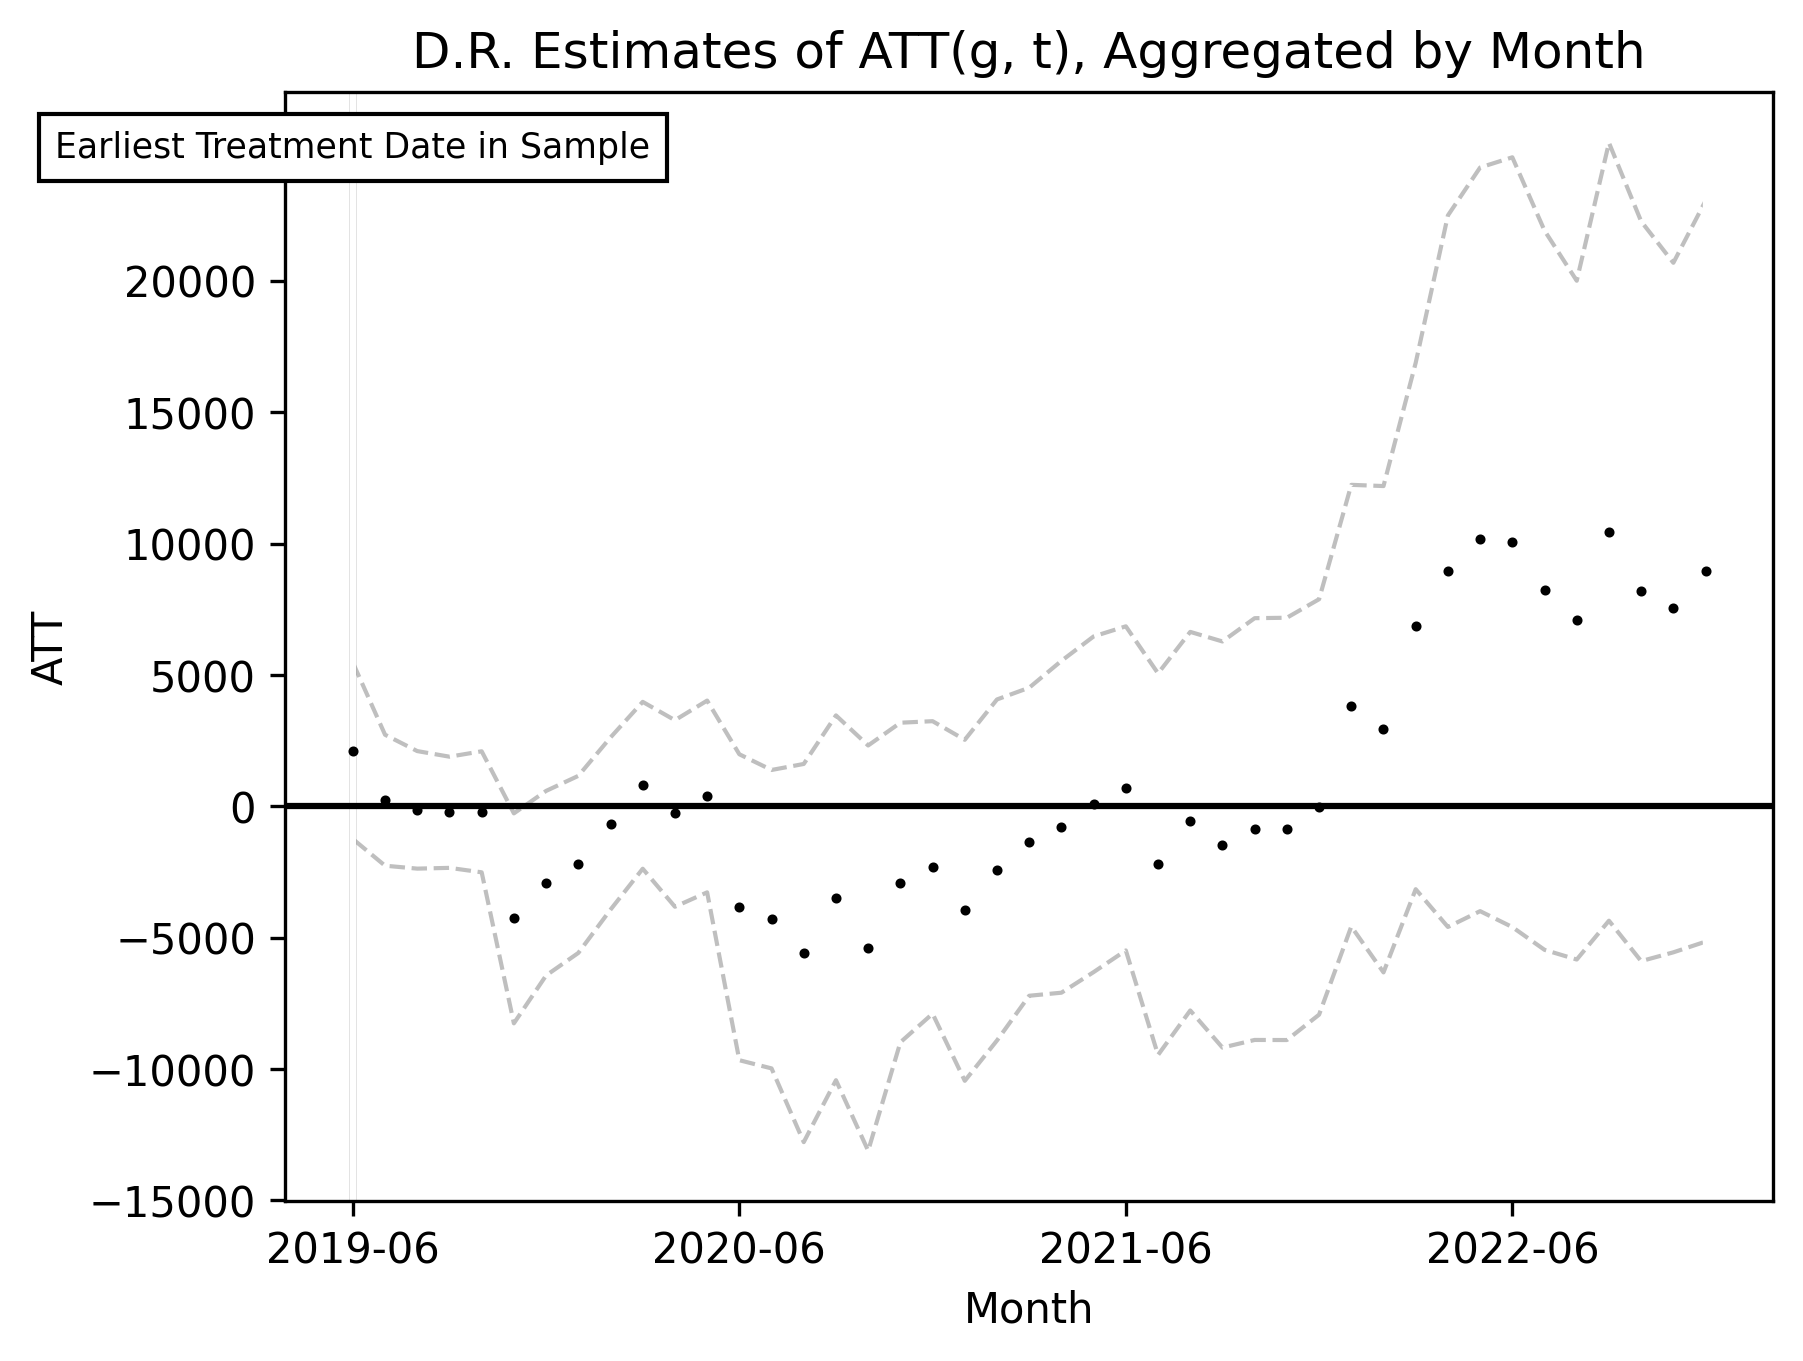

In [32]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")

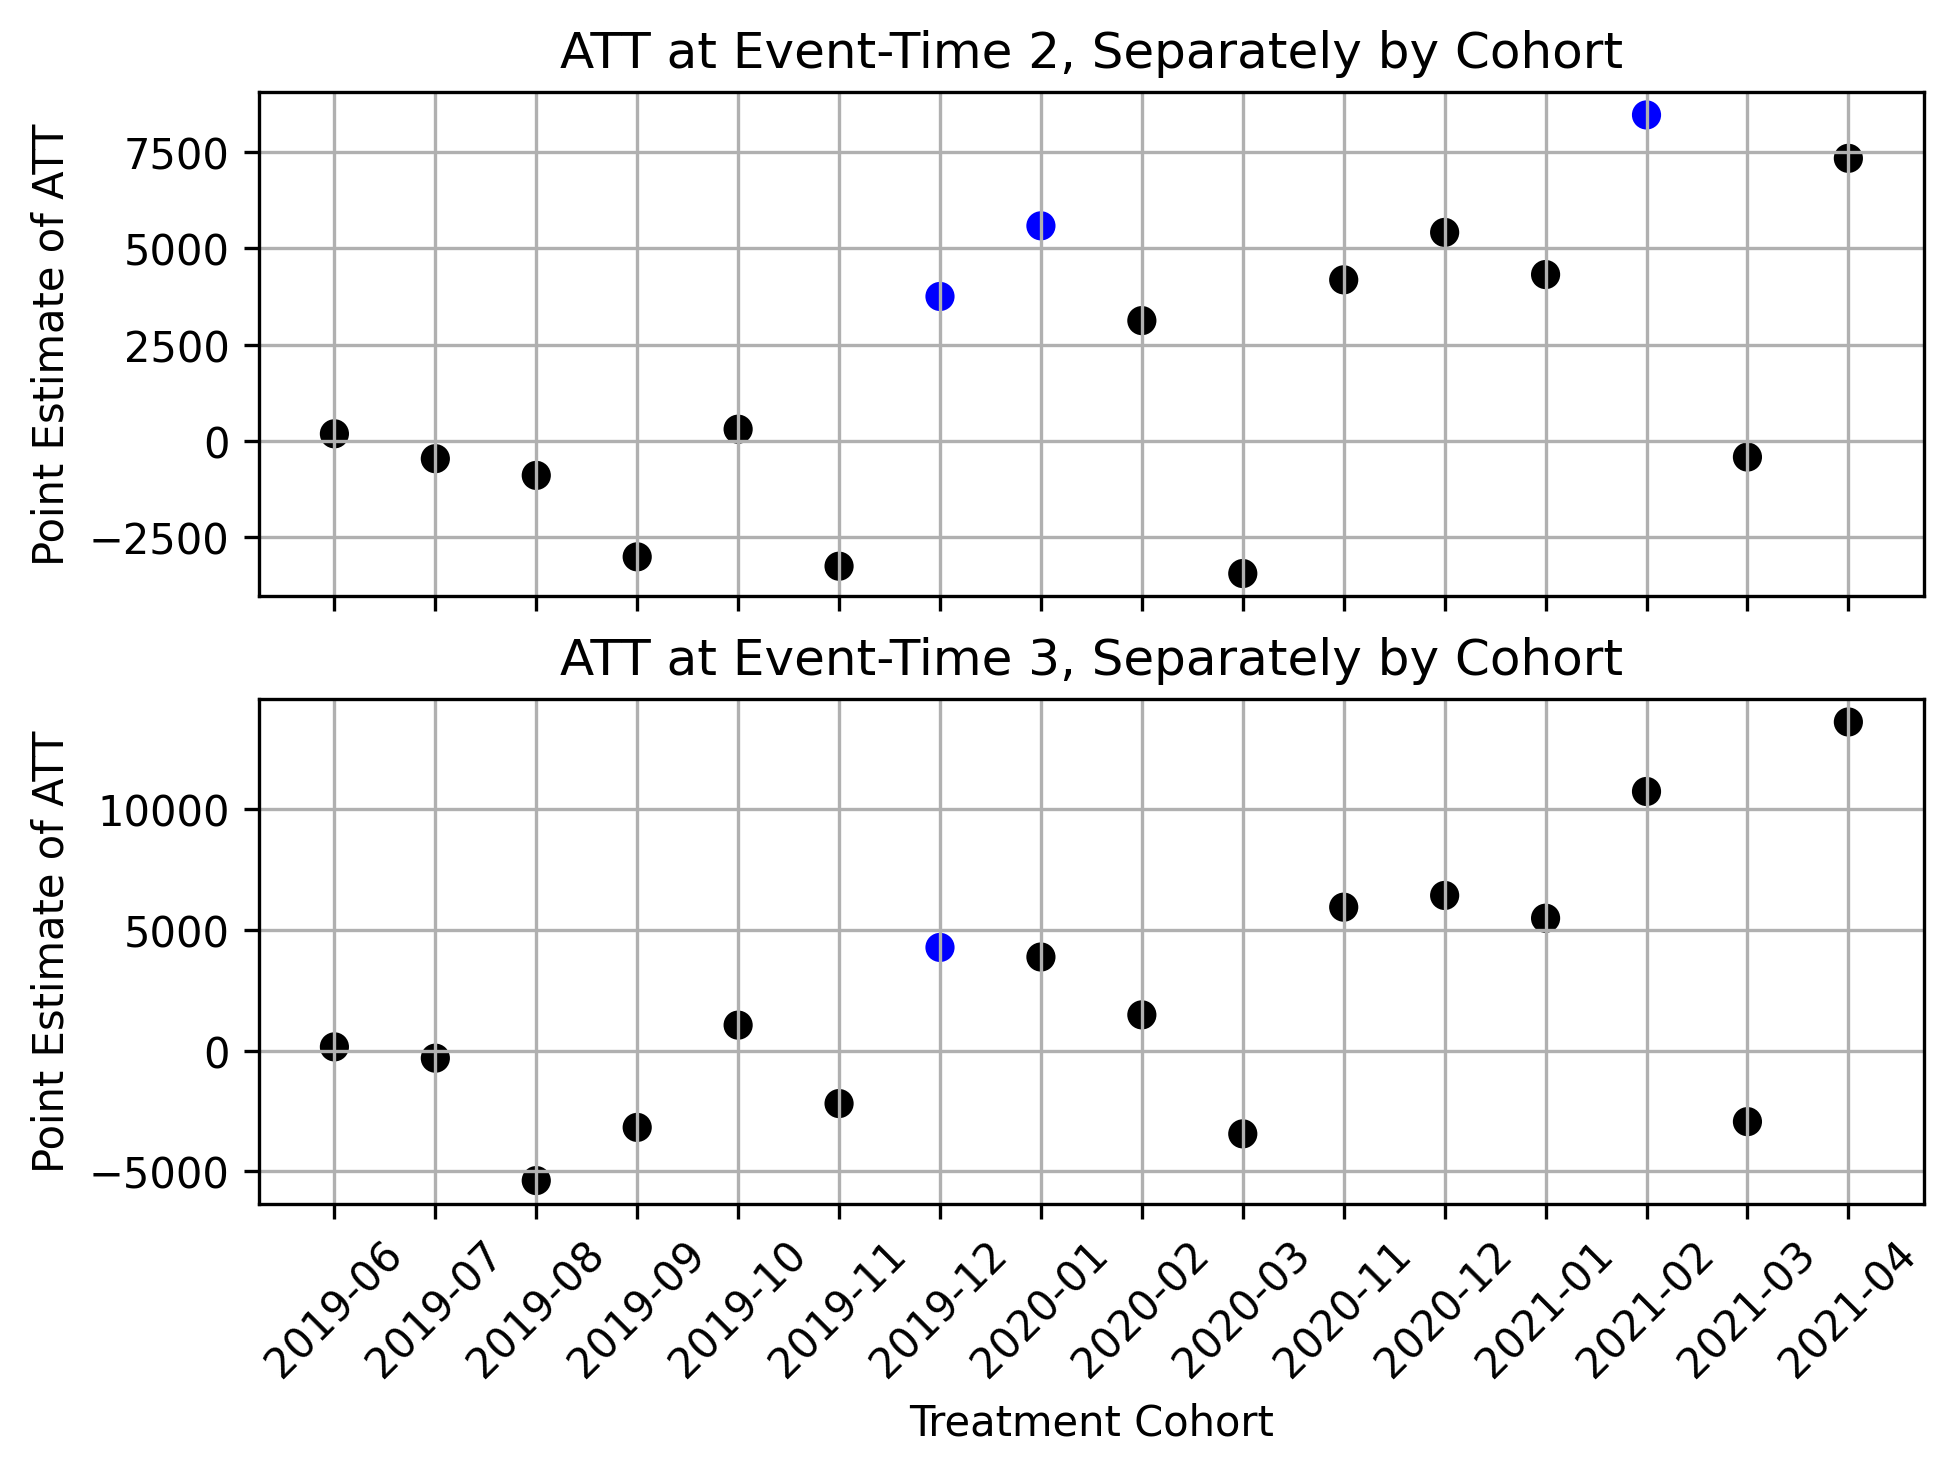

In [33]:
# Analyze heterogeneity in event-time 2 and 3 effects.

# Remove the outer indices of the columns so that we can easily access the ATT estimate and the significance of the estimate.
att_gts = result.copy()
att_gts.columns = att_gts.columns.droplevel(0).droplevel(0)

# Select ATT estimates from event time 2.
event_time_2_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'ATT']
event_time_2_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 2, 'zero_not_in_cband']

# Select ATT estimates from event time 3.
event_time_3_ATTs = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'ATT']
event_time_3_significance = att_gts.loc[att_gts.index.get_level_values(0) == att_gts.index.get_level_values(2) - 3, 'zero_not_in_cband']

fig, axes = plt.subplots(2, 1, sharex=True, layout='constrained')

for event_time_i_ATTS, event_time_i_significance, xlabel, ylabel, title, ax in zip([event_time_2_ATTs, event_time_3_ATTs],
                                                                                   [event_time_2_significance, event_time_3_significance],
                                                                                   ["", "Treatment Cohort"],
                                                                                   ["Point Estimate of ATT", "Point Estimate of ATT"],
                                                                                   ["ATT at Event-Time 2, Separately by Cohort",
                                                                                    "ATT at Event-Time 3, Separately by Cohort"],
                                                                                   axes):
    x = pd.Series(event_time_i_ATTS.index.get_level_values(0)).replace(int_to_month_dictionary).values.tolist()
    y = event_time_i_ATTS.values.tolist()
    colors = event_time_i_significance.replace({'*': 'blue', '': 'black'}).values.tolist()
    ax.scatter(x,
               y,
               color=colors)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
axes[1].tick_params('x', rotation=45)
plt.show()

In [34]:
a

NameError: name 'a' is not defined